# MA
## Moving Averages
이번 단원에서는 우리는 성능과 복잡성 측면에서 Simple Moving Averages와 Weighted Moving Averages를 비교할 것이다.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong><a href='https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html'>pandas.DataFrame.rolling</a></strong><font color=black>(window)</font>&nbsp;&nbsp;
Provides rolling window calculations<br>
<strong><a href='https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html'>pandas.DataFrame.ewm</a></strong><font color=black>(span)</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Provides exponential weighted functions</tt></div></div>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

airline = pd.read_csv('../Data/airline_passengers.csv',
                      index_col='Month',
                      parse_dates=True)
airline.dropna(inplace=True)
airline.index = pd.to_datetime(airline.index)
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


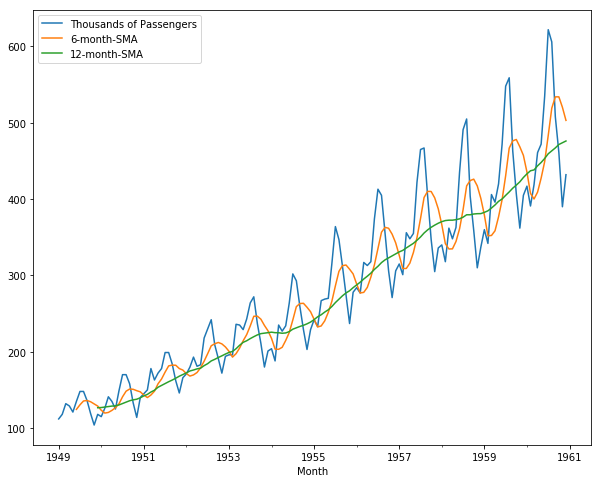

In [2]:
airline['6-month-SMA'] = airline['Thousands of Passengers'].rolling(window=6).mean()
airline['12-month-SMA'] = airline['Thousands of Passengers'].rolling(window=12).mean()

airline.plot(figsize=(10, 8));

# EWMA
## Exponentially Weighted moving Average
우리는 지금까지 SMA를 어떻게 계산하는 지에 대해 알아보았다. 하지만 기본 SMA는 다음과 같은 약점이 존재한다:

1. 전체 모델이 같은 이동 평균 기간으로 제한된다는 것
    - 6개월과 12개월 이동평균의 경우 데이터 셋의 길이가 12개월이나 6개월보다 훨씬 길더라도 데이터셋 전체에 똑같이 적용된다.
    - 데이터 셋의 길이가 10년이나 100년이 되더라도 그 데이터에 대해서 하나의 이동 평균 기간 밖에 적용할 수 없다.
    
    
2. 단순 이동 평균의 약점은 짧은 이동 평균 기간을 이용하면 신호보다 잡음이 커질 수 있다는 점
    - 이동 평균 기간이 짧아질 수록 시계열 데이터를 더 잘 설명할 수 있지만 그만큼 잡음의 크기도 커지게 되기 때문에 적절한 이동 평균 기간을 찾는 것은 굉장히 어렵다.


3. 단순 이동 평균을 하게 되면 이동 평균 기간만큼 시차가 생기게 됨


4. 평균을 함으로 인해서 원래 데이터의 극대값과 극소값에 못 미치는 값을 보임


5. 실제로 미래 변동에 대해 어떠한 정보도 지니고 있지 않고 단순히 현재 데이터의 일반적 추세만을 보여줌


6. 극단적으로 크거나 작은 값은 단순 이동 평균을 왜곡시킬 수 있다.
    - 만일 불황기가 포함된 경제 데이터를 모델하려 한다면 이동 평균 기간이 완전히 불황기를 지날 때까지 계속 경기 침체가 있는 것으로 나타나는데 이는 부정확할 수 있다.

최근의 자료는 다가올 미래의 결과를 조금 더 반영할 수 있다는 가정하에 최근 자료들이 오래된 자료보다 가중된다면 더욱 좋은 결과값이 나올 수 있을 것이다. 이것은 단순 이동 평균 대신 EWMA를 이용하면 가능하다.

EWMA(Exponentially Weighted Moving Averages)는 지수 가중 이동 평균을 뜻하고 단순 이동 평균의 단점을 보완함
- 가장 최근 값에 적용되는 가중치의 양은 EWMA에 사용된 실제 매개 변수와 windew 크기가 주어진 기간 수에 따라 달라짐.
- EWMA는 최근의 값들에 지수적으로 가중치를 적용함으로써 단순 이동 평균에서의 시차 효과를 감소시킬 수 있다.
- 가중 최근의 값에 적용되는 가중치는 추후에 다룰 EWMA의 매개변수에 의해 결정되며 이동 평균 기간에 따라서도 변화함

EWMA의 공식은 다음과 같다:

 $y_t =   \frac{\sum\limits_{i=0}^t w_i x_{t-i}}{\sum\limits_{i=0}^t w_i}$
 
 
- $y_t$: 특정 시간 $t$에 대한 출력값
- $x_t$: 입력값
- $w_i$: 가중치($i=0$에서 $t$로 변할 때 가중치의 값도 업데이트 됨)

그렇다면 $w_i$의 값은 어떻게 정할 수 있을까?

이것은 `.ewm()`의 메소드의 파라미터인 `adjust`를 조정하면서 결정이 된다.

`adjust=True`(default)로 사용할 때, 가중 평균은 $w_i=(1-\alpha)^i$의 가중치 방정식을 사용함으로 계산된다.

그리하여 $y_t$는 다음과 같이 전개된다.

$$y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}$$

$\alpha$의 값은 0~1 사이의 값이기 때문에 데이터가 오래될수록 작은 가중치를 받게 된다.

`adjust=False`로 설정되었을 때 이동평균은 다음과 같이 계산된다:
$$\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$$

이 값은 다음과 같은 가중치를 사용하는 것과 동일함:

\begin{split}w_i = \begin{cases}
    \alpha (1 - \alpha)^i & \text{if } i < t \\
    (1 - \alpha)^i        & \text{if } i = t.
\end{cases}\end{split}

0 보다 크고 1보다 같거나 작아야 하는 $\alpha$는 직접 입력하지 않아도 됨. 대신 지수 가중 이동 평균을 하기 위해 `span`, `center of mass(com)`, `halflife`인자를 이용할 수 있다.

\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{for span}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{for center of mass}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{for half-life}\ h > 0
 \end{cases}\end{split}

- **span**: N일 이동 평균
- **Center of mass**: $C=(s−1)/2$와 같은 값으로 span과는 역관계를 가진다.
- **half-life**: 반감기, 지수적 가중치가 반으로 줄어드는데 걸리는 기간을 의미
- $\alpha$를 직접 설정하여 smoothing의 정도를 조절 가능하다.

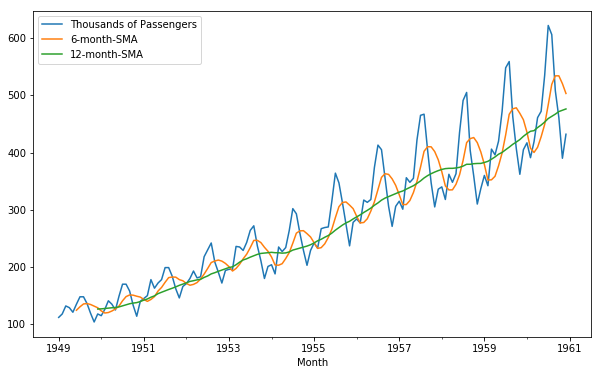

In [5]:
airline[['Thousands of Passengers','6-month-SMA','12-month-SMA']].plot(figsize=(10, 6));

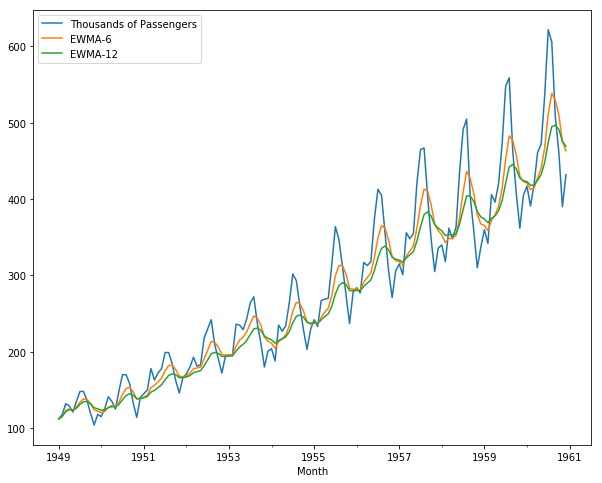

In [7]:
airline['EWMA-12'] = airline['Thousands of Passengers'].ewm(span=12).mean()
airline['EWMA-6'] = airline['Thousands of Passengers'].ewm(span=6).mean()
airline[['Thousands of Passengers', 'EWMA-6', 'EWMA-12']].plot(figsize=(10, 8));